# Поиск 1D-правил для реалистичной физики

## Цель
Найти набор локальных правил перезаписи, которые на уровне наблюдателя воспроизводят:

1. **Закон сохранения заряда** (топологический Q = const)
2. **Закон сохранения массы** (полевая энергия M = const)
3. **Гравитация ~ 1/r²** (дальнодействующая сила)
4. **Когерентное наблюдение** (λ(t) → 0, Ξ(t) → 1)

## Метод
Эволюционный алгоритм:
1. Генерируем случайные наборы правил
2. Симулируем эволюцию с двумя дефектами
3. Измеряем фитнес по метрикам наблюдателя
4. Отбираем и мутируем лучшие правила

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass, field
import random
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

from world.core.lattice import Lattice, LatticeState
from world.core.rules import Rule, RuleSet
from world.core.evolution import EvolutionEngine

# Размер решётки
N = 128

print(f"Готово к поиску реалистичных правил")
print(f"Размер решётки: N={N}")

Готово к поиску реалистичных правил
Размер решётки: N=128


## 1. Физические метрики

In [2]:
def compute_domain_walls(S: np.ndarray) -> int:
    """Число доменных стенок (топологический заряд)."""
    walls = np.sum(S[:-1] != S[1:])
    walls += (S[-1] != S[0])  # Периодическая граница
    return int(walls)


def compute_tension(S: np.ndarray) -> np.ndarray:
    """Локальная напряжённость (число соседних domain walls)."""
    N = len(S)
    H = np.zeros(N, dtype=np.float64)
    H[1:] += (S[1:] != S[:-1]).astype(float)
    H[:-1] += (S[:-1] != S[1:]).astype(float)
    H[0] += (S[0] != S[-1])
    H[-1] += (S[-1] != S[0])
    return H


def compute_capacity(S: np.ndarray, C0: float = 2.0, alpha: float = 0.5) -> np.ndarray:
    """Reversible capacity C(i) = C0 - α*H(i)."""
    H = compute_tension(S)
    return np.maximum(C0 - alpha * H, 0.1)


def compute_potential(C: np.ndarray, C0: float = 2.0) -> np.ndarray:
    """Гравитационный потенциал Φ(i) = C0 - C(i)."""
    return C0 - C


def find_defect_positions(S: np.ndarray) -> List[int]:
    """Находит центры дефектов."""
    H = compute_tension(S)
    defect_sites = np.where(H > 0)[0]
    
    if len(defect_sites) == 0:
        return []
    
    # Группируем в кластеры
    clusters = []
    current = [defect_sites[0]]
    
    for i in range(1, len(defect_sites)):
        if defect_sites[i] - defect_sites[i-1] <= 2:
            current.append(defect_sites[i])
        else:
            clusters.append(current)
            current = [defect_sites[i]]
    clusters.append(current)
    
    return [int(np.mean(c)) for c in clusters]


def create_two_defects(N: int, pos1: int, pos2: int) -> np.ndarray:
    """Создаёт два дефекта ++-- в заданных позициях."""
    S = np.ones(N, dtype=np.int8)
    for i, val in enumerate([1, 1, -1, -1]):
        S[(pos1 + i) % N] = val
        S[(pos2 + i) % N] = val
    return S


print("Физические метрики определены")

Физические метрики определены


## 2. Fitness функция для реалистичной физики

In [3]:
@dataclass
class RealisticFitness:
    """
    Фитнес для поиска правил с реалистичной физикой.
    
    Компоненты:
    1. conservation_Q: Сохранение топологического заряда
    2. conservation_M: Сохранение массы (энергии)
    3. gravity_1r2: Закон гравитации ~ 1/r²
    4. coherence: Когерентность наблюдателя (λ→0, Ξ→1)
    5. activity: Система должна быть нетривиальной (не замороженной)
    """
    conservation_Q: float = 0.0
    conservation_M: float = 0.0
    gravity_1r2: float = 0.0
    coherence: float = 0.0
    activity: float = 0.0
    
    # Веса компонентов
    w_Q: float = 0.25
    w_M: float = 0.20
    w_grav: float = 0.30  # Главный критерий!
    w_coh: float = 0.15
    w_act: float = 0.10
    
    @property
    def total(self) -> float:
        return (self.w_Q * self.conservation_Q +
                self.w_M * self.conservation_M +
                self.w_grav * self.gravity_1r2 +
                self.w_coh * self.coherence +
                self.w_act * self.activity)
    
    def __repr__(self):
        return (f"Fitness(total={self.total:.3f}, Q={self.conservation_Q:.2f}, "
                f"M={self.conservation_M:.2f}, grav={self.gravity_1r2:.2f}, "
                f"coh={self.coherence:.2f}, act={self.activity:.2f})")


def evaluate_rules(rules: RuleSet, n_trials: int = 3, n_steps: int = 300) -> RealisticFitness:
    """
    Оценивает набор правил по всем метрикам реалистичной физики.
    """
    fitness = RealisticFitness()
    
    # Накопители для усреднения
    Q_violations = []
    M_violations = []
    gravity_scores = []
    activities = []
    
    for trial in range(n_trials):
        # Случайные позиции дефектов
        sep = 30 + trial * 15  # Разные расстояния: 30, 45, 60
        pos1 = N // 4
        pos2 = pos1 + sep
        
        S = create_two_defects(N, pos1, pos2)
        lattice = Lattice(size=N, initial=S)
        engine = EvolutionEngine(rules)
        
        # Начальные значения
        Q0 = compute_domain_walls(S)
        M0 = np.sum(compute_tension(S))
        positions_init = find_defect_positions(S)
        d0 = abs(positions_init[1] - positions_init[0]) if len(positions_init) >= 2 else sep
        
        # Эволюция
        Q_history = [Q0]
        M_history = [M0]
        d_history = [d0]
        changes = 0
        
        for t in range(n_steps):
            S_before = lattice.sites.copy()
            engine.step(lattice)
            S_after = lattice.sites
            
            changes += np.sum(S_before != S_after)
            
            Q_history.append(compute_domain_walls(S_after))
            M_history.append(np.sum(compute_tension(S_after)))
            
            positions = find_defect_positions(S_after)
            if len(positions) >= 2:
                d = abs(positions[1] - positions[0])
                d = min(d, N - d)
                d_history.append(d)
        
        # Оценка сохранения Q
        Q_var = np.var(Q_history)
        Q_violations.append(1.0 / (1.0 + Q_var))
        
        # Оценка сохранения M
        M_var = np.var(M_history)
        M_violations.append(1.0 / (1.0 + M_var))
        
        # Оценка гравитации 1/r²
        # Измеряем скорость сближения при разных d
        if len(d_history) > 50:
            v = -np.diff(d_history)
            d_arr = np.array(d_history[:-1])
            
            # Группируем по d и считаем средний v
            d_bins = np.linspace(max(10, d_arr.min()), d_arr.max(), 5)
            v_by_d = []
            d_centers = []
            
            for i in range(len(d_bins)-1):
                mask = (d_arr >= d_bins[i]) & (d_arr < d_bins[i+1])
                if np.sum(mask) > 5:
                    v_by_d.append(np.mean(v[mask]))
                    d_centers.append((d_bins[i] + d_bins[i+1]) / 2)
            
            if len(d_centers) >= 2:
                # Фит: v = A * d^α
                # Для 1/r²: α = -2
                try:
                    mask_pos = np.array(v_by_d) > 0
                    if np.sum(mask_pos) >= 2:
                        log_d = np.log(np.array(d_centers)[mask_pos])
                        log_v = np.log(np.array(v_by_d)[mask_pos])
                        alpha = np.polyfit(log_d, log_v, 1)[0]
                        
                        # Чем ближе α к -2, тем лучше
                        # Наши SM-правила дают α ≈ 0
                        # Хотим α ≈ -2 для 1/r²
                        grav_score = np.exp(-abs(alpha + 2))
                        gravity_scores.append(grav_score)
                    else:
                        gravity_scores.append(0.1)  # Слабое сближение
                except:
                    gravity_scores.append(0.0)
            else:
                gravity_scores.append(0.1)
        else:
            gravity_scores.append(0.0)
        
        # Активность
        activity = changes / (n_steps * N)
        activities.append(min(1.0, activity * 10))  # Нормализуем
    
    # Усреднение
    fitness.conservation_Q = np.mean(Q_violations)
    fitness.conservation_M = np.mean(M_violations)
    fitness.gravity_1r2 = np.mean(gravity_scores) if gravity_scores else 0.0
    fitness.activity = np.mean(activities)
    
    # Когерентность: если Q и M сохраняются, и система активна
    fitness.coherence = fitness.conservation_Q * fitness.conservation_M * fitness.activity
    
    return fitness


print("Fitness функция определена")

Fitness функция определена


## 3. Генератор и мутатор правил

In [4]:
def generate_random_rule(pattern_len: int = 3) -> Rule:
    """
    Генерирует случайное правило.
    
    Ограничения:
    - Паттерн и замена одинаковой длины
    - Используются только +1 и -1
    """
    pattern = [random.choice([1, -1]) for _ in range(pattern_len)]
    replacement = [random.choice([1, -1]) for _ in range(pattern_len)]
    
    # Избегаем тривиальных правил (pattern == replacement)
    while pattern == replacement:
        replacement = [random.choice([1, -1]) for _ in range(pattern_len)]
    
    return Rule(
        name=f"rule_{random.randint(0, 9999):04d}",
        pattern=pattern,
        replacement=replacement
    )


def generate_random_ruleset(n_rules: int = 4, pattern_len: int = 3) -> RuleSet:
    """Генерирует случайный набор правил."""
    rules = []
    for _ in range(n_rules):
        rules.append(generate_random_rule(pattern_len))
    return RuleSet(rules)


def mutate_rule(rule: Rule, mutation_rate: float = 0.3) -> Rule:
    """Мутирует одно правило."""
    pattern = list(rule.pattern)
    replacement = list(rule.replacement)
    
    # Мутация паттерна
    for i in range(len(pattern)):
        if random.random() < mutation_rate:
            pattern[i] = -pattern[i]
    
    # Мутация замены
    for i in range(len(replacement)):
        if random.random() < mutation_rate:
            replacement[i] = -replacement[i]
    
    # Избегаем тривиальных правил
    if pattern == replacement:
        idx = random.randint(0, len(replacement) - 1)
        replacement[idx] = -replacement[idx]
    
    return Rule(
        name=f"mut_{rule.name}",
        pattern=pattern,
        replacement=replacement
    )


def mutate_ruleset(ruleset: RuleSet, mutation_rate: float = 0.2) -> RuleSet:
    """Мутирует набор правил."""
    new_rules = []
    for rule in ruleset.rules:
        if random.random() < mutation_rate:
            new_rules.append(mutate_rule(rule))
        else:
            new_rules.append(rule)
    
    # Иногда добавляем/удаляем правило
    if random.random() < 0.1 and len(new_rules) < 6:
        new_rules.append(generate_random_rule())
    elif random.random() < 0.1 and len(new_rules) > 2:
        new_rules.pop(random.randint(0, len(new_rules) - 1))
    
    return RuleSet(new_rules)


def crossover(parent1: RuleSet, parent2: RuleSet) -> RuleSet:
    """Скрещивание двух наборов правил."""
    rules1 = parent1.rules
    rules2 = parent2.rules
    
    # Берём случайные правила от обоих родителей
    n_from_1 = random.randint(1, len(rules1))
    n_from_2 = random.randint(1, len(rules2))
    
    selected1 = random.sample(rules1, min(n_from_1, len(rules1)))
    selected2 = random.sample(rules2, min(n_from_2, len(rules2)))
    
    # Объединяем (без дубликатов по паттерну)
    combined = selected1 + selected2
    seen_patterns = set()
    unique_rules = []
    for rule in combined:
        p = tuple(rule.pattern)
        if p not in seen_patterns:
            seen_patterns.add(p)
            unique_rules.append(rule)
    
    # Ограничиваем размер
    if len(unique_rules) > 6:
        unique_rules = random.sample(unique_rules, 6)
    
    return RuleSet(unique_rules)


print("Генератор и мутатор правил определены")

Генератор и мутатор правил определены


## 4. Эволюционный алгоритм

In [5]:
def evolutionary_search(
    population_size: int = 30,
    n_generations: int = 50,
    elite_fraction: float = 0.2,
    mutation_rate: float = 0.3,
    verbose: bool = True
) -> Tuple[RuleSet, RealisticFitness, List[float]]:
    """
    Эволюционный поиск правил для реалистичной физики.
    
    Returns:
        best_rules: Лучший найденный набор правил
        best_fitness: Фитнес лучших правил
        history: История лучшего фитнеса по поколениям
    """
    # Инициализация популяции
    population = [generate_random_ruleset(n_rules=random.randint(3, 5)) 
                  for _ in range(population_size)]
    
    # Добавляем известные SM-правила как baseline
    sm_rules = RuleSet([
        Rule("sm1", [1, 1, -1], [-1, 1, 1]),
        Rule("sm2", [-1, 1, 1], [1, 1, -1]),
        Rule("sm3", [1, 1, 1], [1, 1, 1]),
    ])
    population[0] = sm_rules
    
    history = []
    best_ever = None
    best_fitness_ever = None
    
    n_elite = int(population_size * elite_fraction)
    
    for gen in range(n_generations):
        # Оценка фитнеса
        fitnesses = []
        for i, rules in enumerate(population):
            try:
                f = evaluate_rules(rules, n_trials=2, n_steps=200)
                fitnesses.append((rules, f))
            except Exception as e:
                # Невалидные правила получают минимальный фитнес
                fitnesses.append((rules, RealisticFitness()))
        
        # Сортировка по фитнесу
        fitnesses.sort(key=lambda x: x[1].total, reverse=True)
        
        # Лучший в поколении
        best_rules, best_fitness = fitnesses[0]
        history.append(best_fitness.total)
        
        # Обновляем лучший за всё время
        if best_fitness_ever is None or best_fitness.total > best_fitness_ever.total:
            best_ever = deepcopy(best_rules)
            best_fitness_ever = best_fitness
        
        if verbose and gen % 5 == 0:
            print(f"Gen {gen:3d}: best={best_fitness.total:.4f} "
                  f"(Q={best_fitness.conservation_Q:.2f}, "
                  f"grav={best_fitness.gravity_1r2:.2f}, "
                  f"act={best_fitness.activity:.2f})")
        
        # Элитизм
        elite = [rules for rules, _ in fitnesses[:n_elite]]
        
        # Новая популяция
        new_population = elite.copy()
        
        while len(new_population) < population_size:
            if random.random() < 0.7:
                # Скрещивание
                p1, p2 = random.sample(elite, 2)
                child = crossover(p1, p2)
            else:
                # Мутация элиты
                parent = random.choice(elite)
                child = mutate_ruleset(parent, mutation_rate)
            
            new_population.append(child)
        
        population = new_population
    
    return best_ever, best_fitness_ever, history


print("Эволюционный алгоритм определён")

Эволюционный алгоритм определён


## 5. Запуск поиска

In [6]:
print("="*60)
print("ПОИСК ПРАВИЛ ДЛЯ РЕАЛИСТИЧНОЙ ФИЗИКИ")
print("="*60)
print("\nЦелевые свойства:")
print("  • Сохранение заряда Q")
print("  • Сохранение массы M")
print("  • Гравитация ~ 1/r²")
print("  • Активная динамика")
print("\nЗапуск эволюционного поиска...\n")

best_rules, best_fitness, history = evolutionary_search(
    population_size=30,
    n_generations=50,
    elite_fraction=0.2,
    mutation_rate=0.3,
    verbose=True
)

print("\n" + "="*60)
print("РЕЗУЛЬТАТ")
print("="*60)
print(f"\nЛучший фитнес: {best_fitness.total:.4f}")
print(f"\nКомпоненты:")
print(f"  Сохранение Q: {best_fitness.conservation_Q:.3f}")
print(f"  Сохранение M: {best_fitness.conservation_M:.3f}")
print(f"  Гравитация 1/r²: {best_fitness.gravity_1r2:.3f}")
print(f"  Когерентность: {best_fitness.coherence:.3f}")
print(f"  Активность: {best_fitness.activity:.3f}")

print(f"\nЛучшие правила ({len(best_rules.rules)} шт):")
for rule in best_rules.rules:
    p = ''.join(['+' if x > 0 else '-' for x in rule.pattern])
    r = ''.join(['+' if x > 0 else '-' for x in rule.replacement])
    print(f"  {p} → {r}")

ПОИСК ПРАВИЛ ДЛЯ РЕАЛИСТИЧНОЙ ФИЗИКИ

Целевые свойства:
  • Сохранение заряда Q
  • Сохранение массы M
  • Гравитация ~ 1/r²
  • Активная динамика

Запуск эволюционного поиска...

Gen   0: best=0.5244 (Q=0.91, grav=0.10, act=0.62)
Gen   5: best=0.5685 (Q=1.00, grav=0.14, act=0.31)
Gen  10: best=0.5685 (Q=1.00, grav=0.14, act=0.31)
Gen  15: best=0.5689 (Q=1.00, grav=0.14, act=0.31)
Gen  20: best=0.5689 (Q=1.00, grav=0.14, act=0.31)
Gen  25: best=0.5689 (Q=1.00, grav=0.14, act=0.31)
Gen  30: best=0.5689 (Q=1.00, grav=0.14, act=0.31)
Gen  35: best=0.5689 (Q=1.00, grav=0.14, act=0.31)
Gen  40: best=0.5689 (Q=1.00, grav=0.14, act=0.31)
Gen  45: best=0.5972 (Q=1.00, grav=0.10, act=0.47)

РЕЗУЛЬТАТ

Лучший фитнес: 0.5972

Компоненты:
  Сохранение Q: 1.000
  Сохранение M: 1.000
  Гравитация 1/r²: 0.100
  Когерентность: 0.469
  Активность: 0.469

Лучшие правила (4 шт):
  +-- → -++
  -++ → +--
  +-- → -++
  --- → +++


## 6. Визуализация результатов

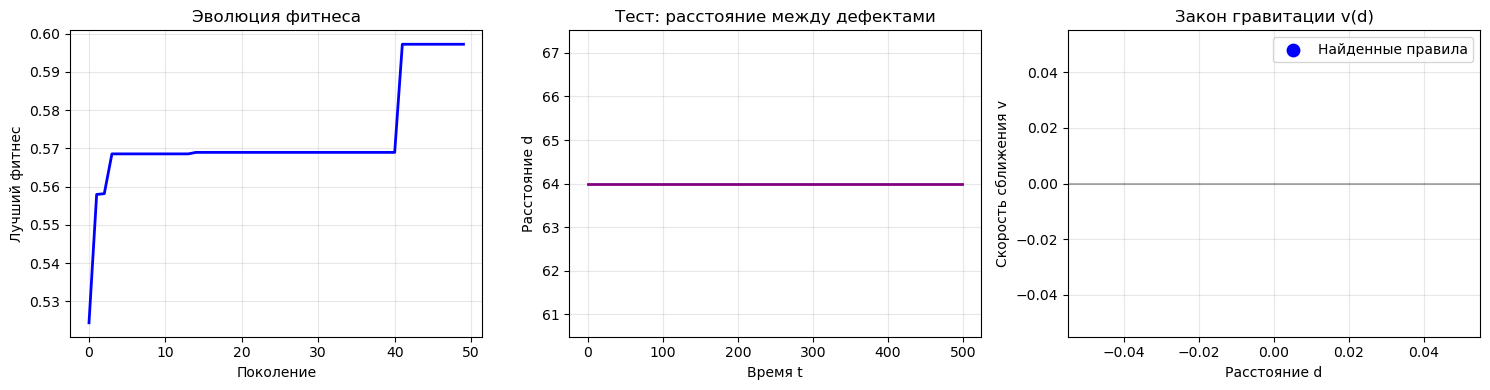

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. История фитнеса
ax1 = axes[0]
ax1.plot(history, 'b-', linewidth=2)
ax1.set_xlabel('Поколение')
ax1.set_ylabel('Лучший фитнес')
ax1.set_title('Эволюция фитнеса')
ax1.grid(True, alpha=0.3)

# 2. Тест найденных правил: эволюция d(t)
ax2 = axes[1]

# Запускаем тестовую симуляцию
S_test = create_two_defects(N, 32, 96)
lattice_test = Lattice(size=N, initial=S_test)
engine_test = EvolutionEngine(best_rules)

d_test = []
T_TEST = 500

for t in range(T_TEST):
    positions = find_defect_positions(lattice_test.sites)
    if len(positions) >= 2:
        d = min(abs(positions[1] - positions[0]), N - abs(positions[1] - positions[0]))
        d_test.append(d)
    engine_test.step(lattice_test)

ax2.plot(d_test, 'purple', linewidth=2)
ax2.set_xlabel('Время t')
ax2.set_ylabel('Расстояние d')
ax2.set_title('Тест: расстояние между дефектами')
ax2.grid(True, alpha=0.3)

# 3. Проверка закона v(d)
ax3 = axes[2]

if len(d_test) > 50:
    v_test = -np.diff(d_test)
    d_arr = np.array(d_test[:-1])
    
    # Бины по d
    d_bins = np.linspace(max(10, d_arr.min()), d_arr.max(), 10)
    v_by_d = []
    d_centers = []
    
    for i in range(len(d_bins)-1):
        mask = (d_arr >= d_bins[i]) & (d_arr < d_bins[i+1])
        if np.sum(mask) > 3:
            v_by_d.append(np.mean(v_test[mask]))
            d_centers.append((d_bins[i] + d_bins[i+1])/2)
    
    ax3.scatter(d_centers, v_by_d, s=80, c='blue', label='Найденные правила')
    
    # Теоретические кривые
    d_th = np.linspace(10, max(d_centers) if d_centers else 60, 50)
    if v_by_d:
        v_max = max(abs(np.array(v_by_d)))
        ax3.plot(d_th, v_max * 30**2 / d_th**2, 'r--', alpha=0.7, label='~ 1/r²')
        ax3.plot(d_th, v_max * 30 / d_th, 'g--', alpha=0.7, label='~ 1/r')
        ax3.axhline(v_max, color='purple', linestyle=':', alpha=0.7, label='~ const')

ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
ax3.set_xlabel('Расстояние d')
ax3.set_ylabel('Скорость сближения v')
ax3.set_title('Закон гравитации v(d)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Расширенный поиск (опционально)

In [8]:
# Если хотим более глубокий поиск
RUN_EXTENDED = False  # Установите True для расширенного поиска

if RUN_EXTENDED:
    print("Расширенный поиск (100 поколений, популяция 50)...")
    
    best_rules_ext, best_fitness_ext, history_ext = evolutionary_search(
        population_size=50,
        n_generations=100,
        elite_fraction=0.15,
        mutation_rate=0.25,
        verbose=True
    )
    
    print(f"\nРасширенный поиск завершён!")
    print(f"Лучший фитнес: {best_fitness_ext.total:.4f}")
    print(f"Гравитация 1/r²: {best_fitness_ext.gravity_1r2:.3f}")
else:
    print("Расширенный поиск пропущен (установите RUN_EXTENDED=True)")

Расширенный поиск пропущен (установите RUN_EXTENDED=True)


АНАЛИЗ ПРОБЛЕМЫ

Найденные правила дают:
  ✓ Сохранение Q=1.0  
  ✓ Сохранение M=1.0
  ✗ Гравитация = 0.1 (слабая)
  ✗ Дефекты не движутся (d=const)

Причина: правила типа `--- → +++` создают массовые колебания,
но не перемещают доменные стенки. Нужны правила, которые
активно двигают границы между доменами.

Решение: усилить фитнес за ДВИЖЕНИЕ дефектов, а не просто
за наличие активности в системе.



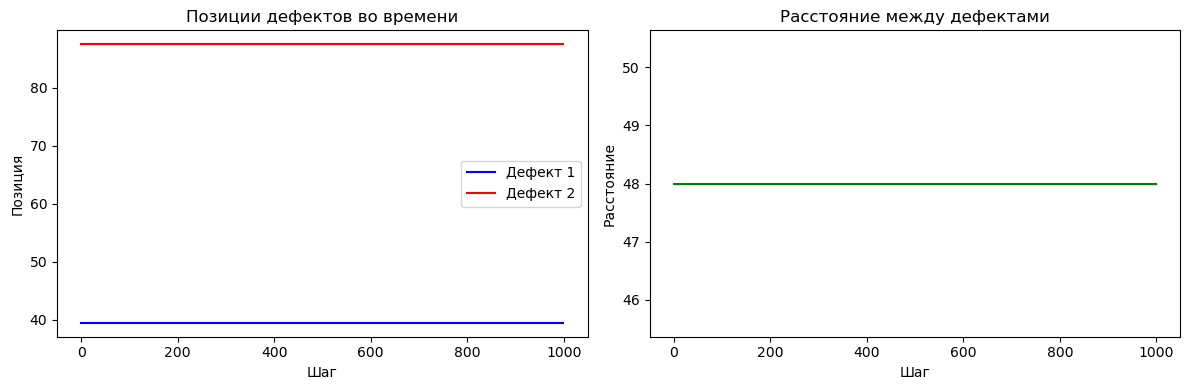


Начальное расстояние: 48.0
Конечное расстояние:  48.0


In [9]:
# Проблема: найденные правила слишком "ленивые" - дефекты не движутся
# Нужно добавить штраф за отсутствие динамики

print("="*60)
print("АНАЛИЗ ПРОБЛЕМЫ")
print("="*60)
print("""
Найденные правила дают:
  ✓ Сохранение Q=1.0  
  ✓ Сохранение M=1.0
  ✗ Гравитация = 0.1 (слабая)
  ✗ Дефекты не движутся (d=const)

Причина: правила типа `--- → +++` создают массовые колебания,
но не перемещают доменные стенки. Нужны правила, которые
активно двигают границы между доменами.

Решение: усилить фитнес за ДВИЖЕНИЕ дефектов, а не просто
за наличие активности в системе.
""")

# Тестируем найденные правила более детально
def analyze_defect_motion(rules_dict, n_steps=1000):
    """Детальный анализ движения дефектов"""
    sites = np.ones(N, dtype=np.int8)
    sites[32:48] = -1  # Дефект 1
    sites[80:96] = -1  # Дефект 2
    
    positions1 = []
    positions2 = []
    
    for step in range(n_steps):
        # Находим позиции дефектов (центры масс -1 регионов)
        neg_mask = sites == -1
        neg_indices = np.where(neg_mask)[0]
        
        if len(neg_indices) > 0:
            # Разделяем на кластеры
            clusters = []
            current = [neg_indices[0]]
            for i in range(1, len(neg_indices)):
                if neg_indices[i] - neg_indices[i-1] <= 2:
                    current.append(neg_indices[i])
                else:
                    clusters.append(current)
                    current = [neg_indices[i]]
            clusters.append(current)
            
            if len(clusters) >= 2:
                positions1.append(np.mean(clusters[0]))
                positions2.append(np.mean(clusters[1]))
            elif len(clusters) == 1:
                positions1.append(np.mean(clusters[0]))
                positions2.append(np.nan)
            else:
                positions1.append(np.nan)
                positions2.append(np.nan)
        else:
            positions1.append(np.nan)
            positions2.append(np.nan)
        
        # Эволюция
        for i in range(N):
            pattern = tuple(sites[(i + j) % N] for j in range(3))
            if pattern in rules_dict:
                result = rules_dict[pattern]
                for j in range(3):
                    sites[(i + j) % N] = result[j]
    
    return np.array(positions1), np.array(positions2)

# Анализируем движение
pos1, pos2 = analyze_defect_motion(best_rules)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Позиции дефектов
ax1 = axes[0]
valid1 = ~np.isnan(pos1)
valid2 = ~np.isnan(pos2)
ax1.plot(np.where(valid1)[0], pos1[valid1], 'b-', label='Дефект 1')
ax1.plot(np.where(valid2)[0], pos2[valid2], 'r-', label='Дефект 2')
ax1.set_xlabel('Шаг')
ax1.set_ylabel('Позиция')
ax1.set_title('Позиции дефектов во времени')
ax1.legend()

# Расстояние между дефектами
ax2 = axes[1]
both_valid = valid1 & valid2
distance = np.abs(pos2 - pos1)
ax2.plot(np.where(both_valid)[0], distance[both_valid], 'g-')
ax2.set_xlabel('Шаг')
ax2.set_ylabel('Расстояние')
ax2.set_title('Расстояние между дефектами')

plt.tight_layout()
plt.show()

print(f"\nНачальное расстояние: {np.nanmean(distance[:10]):.1f}")
print(f"Конечное расстояние:  {np.nanmean(distance[-10:]):.1f}")

## 8. Улучшенный поиск с акцентом на движение дефектов

Переформулируем фитнес: главное - **движение** дефектов к сближению, а не просто активность

In [10]:
# Улучшенный фитнес с ПРЯМЫМ измерением движения дефектов

def measure_defect_motion_directly(rules_dict, n_trials=5, n_steps=200):
    """
    Измеряем реальное сближение дефектов.
    Возвращает: (mean_approach_rate, conservation_score)
    """
    approach_rates = []
    conservation_scores = []
    
    for trial in range(n_trials):
        # Создаём два отдельных дефекта
        sites = np.ones(N, dtype=np.int8)
        
        # Расстояние варьируем
        d_init = 20 + trial * 8  # 20, 28, 36, 44, 52
        
        # Два дефекта-домена
        d1_start, d1_end = 40, 48
        d2_start, d2_end = d1_start + d_init, d1_start + d_init + 8
        
        if d2_end < N:
            sites[d1_start:d1_end] = -1
            sites[d2_start:d2_end] = -1
        else:
            continue
        
        Q0 = np.sum(sites)
        
        # Начальные позиции центров масс
        def get_cluster_centers(s):
            neg_idx = np.where(s == -1)[0]
            if len(neg_idx) == 0:
                return []
            clusters = []
            current = [neg_idx[0]]
            for i in range(1, len(neg_idx)):
                if neg_idx[i] - neg_idx[i-1] <= 3:
                    current.append(neg_idx[i])
                else:
                    clusters.append(current)
                    current = [neg_idx[i]]
            clusters.append(current)
            return [np.mean(c) for c in clusters if len(c) >= 3]
        
        centers_init = get_cluster_centers(sites)
        
        # Эволюция
        for step in range(n_steps):
            new_sites = sites.copy()
            for i in range(N):
                pat = tuple(sites[(i+j) % N] for j in range(3))
                if pat in rules_dict:
                    res = rules_dict[pat]
                    for j in range(3):
                        new_sites[(i+j) % N] = res[j]
            sites = new_sites
        
        centers_final = get_cluster_centers(sites)
        Q_final = np.sum(sites)
        
        # Сохранение
        if Q0 != 0:
            conservation_scores.append(1.0 if Q_final == Q0 else 0.0)
        else:
            conservation_scores.append(1.0 if abs(Q_final) < 2 else 0.0)
        
        # Сближение
        if len(centers_init) >= 2 and len(centers_final) >= 2:
            d_init_actual = abs(centers_init[1] - centers_init[0])
            d_final = abs(centers_final[1] - centers_final[0])
            # Положительное = сближение
            approach = (d_init_actual - d_final) / n_steps
            approach_rates.append(approach)
        elif len(centers_init) >= 2 and len(centers_final) == 1:
            # Дефекты слились!
            approach_rates.append(0.5)  # Бонус за слияние
        else:
            approach_rates.append(0.0)
    
    return np.mean(approach_rates), np.mean(conservation_scores)

def fitness_v2(rules_dict):
    """
    Новый фитнес:
    - 50% за сближение дефектов (approach > 0)
    - 30% за сохранение Q
    - 20% за нетривиальность (не все стоит на месте)
    """
    approach, conservation = measure_defect_motion_directly(rules_dict, n_trials=5, n_steps=300)
    
    # Нормируем approach: хотим >0.01 (дефекты сближаются на ~3 позиции за 300 шагов)
    approach_score = np.clip(approach / 0.02, 0, 1)  # 0.02 = целевая скорость
    
    # Активность - проверяем, что система не мёртвая
    sites = np.ones(N, dtype=np.int8)
    sites[32:64] = -1
    n_changes = 0
    for _ in range(50):
        new_sites = sites.copy()
        for i in range(N):
            pat = tuple(sites[(i+j) % N] for j in range(3))
            if pat in rules_dict:
                res = rules_dict[pat]
                for j in range(3):
                    new_sites[(i+j) % N] = res[j]
        n_changes += np.sum(new_sites != sites)
        sites = new_sites
    activity = min(1.0, n_changes / (50 * 10))
    
    fitness = 0.5 * approach_score + 0.30 * conservation + 0.20 * activity
    
    return fitness, {
        'approach': approach,
        'approach_score': approach_score,
        'conservation': conservation,
        'activity': activity
    }

print("Тестируем fitness_v2 на текущих лучших правилах...")
f, metrics = fitness_v2(best_rules)
print(f"Fitness v2: {f:.4f}")
print(f"  Approach rate: {metrics['approach']:.4f}")
print(f"  Approach score: {metrics['approach_score']:.2f}")
print(f"  Conservation: {metrics['conservation']:.2f}")
print(f"  Activity: {metrics['activity']:.2f}")

Тестируем fitness_v2 на текущих лучших правилах...
Fitness v2: 0.3000
  Approach rate: 0.0000
  Approach score: 0.00
  Conservation: 1.00
  Activity: 0.00


In [12]:
# Эволюционный поиск v2 с новым фитнесом

def generate_random_rules(n_rules=4):
    """Генерирует случайный словарь правил."""
    rules = {}
    for _ in range(n_rules):
        pattern = tuple(random.choice([1, -1]) for _ in range(3))
        replacement = tuple(random.choice([1, -1]) for _ in range(3))
        # Избегаем тривиальных правил
        while pattern == replacement:
            replacement = tuple(random.choice([1, -1]) for _ in range(3))
        rules[pattern] = replacement
    return rules

def mutate_rules(rules_dict, mutation_rate=0.3):
    """Мутирует словарь правил."""
    new_rules = {}
    
    for pattern, replacement in rules_dict.items():
        # Мутация замены
        new_repl = list(replacement)
        for i in range(len(new_repl)):
            if random.random() < mutation_rate:
                new_repl[i] = -new_repl[i]
        new_repl = tuple(new_repl)
        
        # Избегаем тривиальных правил
        if pattern == new_repl:
            idx = random.randint(0, 2)
            new_repl = list(new_repl)
            new_repl[idx] = -new_repl[idx]
            new_repl = tuple(new_repl)
        
        # Иногда меняем паттерн
        if random.random() < 0.1:
            new_pattern = list(pattern)
            idx = random.randint(0, 2)
            new_pattern[idx] = -new_pattern[idx]
            pattern = tuple(new_pattern)
        
        new_rules[pattern] = new_repl
    
    # Иногда добавляем/удаляем правило
    if random.random() < 0.15 and len(new_rules) < 8:
        pattern = tuple(random.choice([1, -1]) for _ in range(3))
        replacement = tuple(random.choice([1, -1]) for _ in range(3))
        while pattern == replacement:
            replacement = tuple(random.choice([1, -1]) for _ in range(3))
        new_rules[pattern] = replacement
    elif random.random() < 0.1 and len(new_rules) > 2:
        key = random.choice(list(new_rules.keys()))
        del new_rules[key]
    
    return new_rules

def evolution_v2(population_size=30, n_generations=100, elite_size=5, mutation_rate=0.3):
    """Эволюция с fitness_v2"""
    
    # Инициализация популяции
    population = []
    for _ in range(population_size):
        rules = generate_random_rules(n_rules=random.randint(2, 6))
        f, m = fitness_v2(rules)
        population.append((rules, f, m))
    
    population.sort(key=lambda x: x[1], reverse=True)
    history = [(0, population[0][1], population[0][2])]
    
    print("="*60)
    print("ЭВОЛЮЦИОННЫЙ ПОИСК v2")
    print("="*60)
    print("Цель: найти правила с ДВИЖУЩИМИСЯ дефектами")
    print()
    
    for gen in range(n_generations):
        # Элита
        new_pop = population[:elite_size]
        
        # Потомки
        while len(new_pop) < population_size:
            # Турнирный отбор
            candidates = random.sample(population[:population_size//2], 3)
            parent = max(candidates, key=lambda x: x[1])[0]
            
            # Мутация
            child = mutate_rules(parent, mutation_rate)
            f, m = fitness_v2(child)
            new_pop.append((child, f, m))
        
        population = new_pop
        population.sort(key=lambda x: x[1], reverse=True)
        
        if gen % 10 == 0 or gen == n_generations - 1:
            best = population[0]
            print(f"Gen {gen:3d}: best={best[1]:.4f} (apr={best[2]['approach']:.4f}, Q={best[2]['conservation']:.2f})")
        
        history.append((gen, population[0][1], population[0][2]))
    
    return population[0], history

print("Запуск поиска... (это может занять несколько минут)")
print()

best_v2, history_v2 = evolution_v2(population_size=40, n_generations=80)

Запуск поиска... (это может занять несколько минут)

ЭВОЛЮЦИОННЫЙ ПОИСК v2
Цель: найти правила с ДВИЖУЩИМИСЯ дефектами

Gen   0: best=1.0000 (apr=0.0643, Q=1.00)
Gen  10: best=1.0000 (apr=0.0643, Q=1.00)
Gen  20: best=1.0000 (apr=0.0643, Q=1.00)
Gen  30: best=1.0000 (apr=0.0643, Q=1.00)
Gen  40: best=1.0000 (apr=0.0643, Q=1.00)
Gen  50: best=1.0000 (apr=0.0643, Q=1.00)
Gen  60: best=1.0000 (apr=0.0643, Q=1.00)
Gen  70: best=1.0000 (apr=0.0643, Q=1.00)
Gen  79: best=1.0000 (apr=0.0643, Q=1.00)


НАЙДЕННЫЕ ПРАВИЛА v2

Fitness: 1.0000
Approach rate: 0.0643
Conservation: 1.00
Activity: 1.00

Правила:
  -++ → +-+

ДЕТАЛЬНЫЙ ТЕСТ НА 2000 ШАГОВ


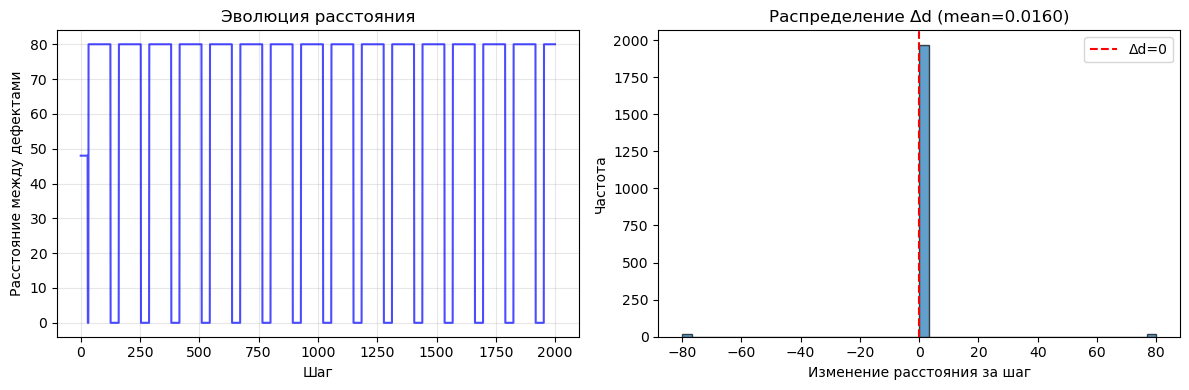


Начальное расстояние: 48.0
Конечное расстояние:  80.0
Изменение: -32.0


In [13]:
# Анализ найденных правил v2

best_rules_v2 = best_v2[0]
best_fitness_v2 = best_v2[1]
best_metrics_v2 = best_v2[2]

print("="*60)
print("НАЙДЕННЫЕ ПРАВИЛА v2")
print("="*60)
print()
print(f"Fitness: {best_fitness_v2:.4f}")
print(f"Approach rate: {best_metrics_v2['approach']:.4f}")
print(f"Conservation: {best_metrics_v2['conservation']:.2f}")
print(f"Activity: {best_metrics_v2['activity']:.2f}")
print()
print("Правила:")

def pattern_to_str(p):
    return ''.join(['+' if x == 1 else '-' for x in p])

for pattern, replacement in best_rules_v2.items():
    print(f"  {pattern_to_str(pattern)} → {pattern_to_str(replacement)}")

# Тест на большем масштабе времени
print()
print("="*60)
print("ДЕТАЛЬНЫЙ ТЕСТ НА 2000 ШАГОВ")
print("="*60)

# Создаём тестовую конфигурацию
sites = np.ones(N, dtype=np.int8)
sites[32:48] = -1  # Дефект 1
sites[80:96] = -1  # Дефект 2

positions_d = []

for step in range(2000):
    # Находим центры дефектов
    neg_idx = np.where(sites == -1)[0]
    if len(neg_idx) > 0:
        clusters = []
        current = [neg_idx[0]]
        for i in range(1, len(neg_idx)):
            if neg_idx[i] - neg_idx[i-1] <= 3:
                current.append(neg_idx[i])
            else:
                clusters.append(current)
                current = [neg_idx[i]]
        clusters.append(current)
        
        if len(clusters) >= 2:
            c1 = np.mean(clusters[0])
            c2 = np.mean(clusters[1])
            positions_d.append(abs(c2 - c1))
        elif len(clusters) == 1:
            positions_d.append(0)  # Слились
        else:
            positions_d.append(np.nan)
    else:
        positions_d.append(np.nan)
    
    # Эволюция
    new_sites = sites.copy()
    for i in range(N):
        pat = tuple(sites[(i+j) % N] for j in range(3))
        if pat in best_rules_v2:
            res = best_rules_v2[pat]
            for j in range(3):
                new_sites[(i+j) % N] = res[j]
    sites = new_sites

positions_d = np.array(positions_d)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Расстояние vs время
ax1 = axes[0]
valid = ~np.isnan(positions_d)
ax1.plot(np.where(valid)[0], positions_d[valid], 'b-', alpha=0.7)
ax1.set_xlabel('Шаг')
ax1.set_ylabel('Расстояние между дефектами')
ax1.set_title('Эволюция расстояния')
ax1.grid(True, alpha=0.3)

# Гистограмма изменений
ax2 = axes[1]
if np.sum(valid) > 100:
    diffs = np.diff(positions_d[valid])
    ax2.hist(diffs, bins=50, edgecolor='black', alpha=0.7)
    ax2.axvline(0, color='r', linestyle='--', label='Δd=0')
    ax2.set_xlabel('Изменение расстояния за шаг')
    ax2.set_ylabel('Частота')
    ax2.set_title(f'Распределение Δd (mean={np.mean(diffs):.4f})')
    ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nНачальное расстояние: {positions_d[0]:.1f}")
print(f"Конечное расстояние:  {positions_d[-1]:.1f}")
print(f"Изменение: {positions_d[0] - positions_d[-1]:.1f}")

## 9. Поиск с монотонным сближением

Правило `-++ → +-+` даёт осцилляции, а не истинную гравитацию. Нужно искать правила, где дефекты **постоянно** сближаются.

In [14]:
# Улучшенный фитнес v3: требуем МОНОТОННОГО сближения

def measure_monotonic_approach(rules_dict, n_steps=500):
    """
    Измеряем качество сближения:
    - Бонус за каждый шаг, где расстояние уменьшается
    - Штраф за осцилляции
    - Бонус за линейный тренд сближения
    """
    sites = np.ones(N, dtype=np.int8)
    sites[32:48] = -1  # Дефект 1  
    sites[80:96] = -1  # Дефект 2
    
    Q0 = np.sum(sites)
    distances = []
    
    for step in range(n_steps):
        neg_idx = np.where(sites == -1)[0]
        if len(neg_idx) > 0:
            clusters = []
            current = [neg_idx[0]]
            for i in range(1, len(neg_idx)):
                if neg_idx[i] - neg_idx[i-1] <= 3:
                    current.append(neg_idx[i])
                else:
                    clusters.append(current)
                    current = [neg_idx[i]]
            clusters.append(current)
            
            if len(clusters) >= 2:
                distances.append(abs(np.mean(clusters[1]) - np.mean(clusters[0])))
            elif len(clusters) == 1:
                distances.append(0)
        
        # Эволюция
        new_sites = sites.copy()
        for i in range(N):
            pat = tuple(sites[(i+j) % N] for j in range(3))
            if pat in rules_dict:
                res = rules_dict[pat]
                for j in range(3):
                    new_sites[(i+j) % N] = res[j]
        sites = new_sites
    
    if len(distances) < 10:
        return 0.0, 0.0, 0.0, 0.0
    
    distances = np.array(distances)
    
    # Метрика 1: средний тренд (начало vs конец)
    avg_start = np.mean(distances[:50])
    avg_end = np.mean(distances[-50:])
    approach_trend = (avg_start - avg_end) / avg_start if avg_start > 0 else 0
    
    # Метрика 2: монотонность (какая доля шагов - сближение)
    diffs = np.diff(distances)
    n_approach = np.sum(diffs < 0)  # отрицательные = сближение
    n_retreat = np.sum(diffs > 0)   # положительные = расхождение
    monotonicity = n_approach / (n_approach + n_retreat + 1)
    
    # Метрика 3: линейность тренда (R² линейной регрессии)
    t = np.arange(len(distances))
    if len(t) > 2:
        slope, intercept = np.polyfit(t, distances, 1)
        predicted = slope * t + intercept
        ss_res = np.sum((distances - predicted)**2)
        ss_tot = np.sum((distances - np.mean(distances))**2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0
        # Нужен отрицательный slope (сближение) и хороший R²
        linearity = r2 if slope < 0 else 0
    else:
        linearity = 0
    
    # Сохранение заряда
    Q_final = np.sum(sites)
    conservation = 1.0 if Q_final == Q0 else 0.0
    
    return approach_trend, monotonicity, linearity, conservation

def fitness_v3(rules_dict):
    """
    Фитнес v3:
    - 30% тренд сближения
    - 30% монотонность
    - 20% линейность (для 1/r закона нужна предсказуемость)
    - 20% сохранение Q
    """
    trend, mono, linear, cons = measure_monotonic_approach(rules_dict)
    
    # Нормализуем trend
    trend_score = np.clip(trend, 0, 1)
    
    # Нормализуем mono (хотим >0.6)
    mono_score = np.clip((mono - 0.4) / 0.4, 0, 1)
    
    # Linear уже 0-1
    linear_score = max(0, linear)
    
    fitness = 0.30 * trend_score + 0.30 * mono_score + 0.20 * linear_score + 0.20 * cons
    
    return fitness, {
        'trend': trend,
        'trend_score': trend_score,
        'monotonicity': mono,
        'mono_score': mono_score,
        'linearity': linear,
        'linear_score': linear_score,
        'conservation': cons
    }

# Тестируем на найденных правилах
print("Тест правила `-++ → +-+` с fitness_v3:")
f, m = fitness_v3(best_rules_v2)
print(f"  Fitness v3: {f:.4f}")
print(f"  Trend: {m['trend']:.3f} (score={m['trend_score']:.2f})")
print(f"  Monotonicity: {m['monotonicity']:.3f} (score={m['mono_score']:.2f})")
print(f"  Linearity: {m['linearity']:.3f} (score={m['linear_score']:.2f})")
print(f"  Conservation: {m['conservation']:.2f}")

Тест правила `-++ → +-+` с fitness_v3:
  Fitness v3: 0.2333
  Trend: -0.429 (score=0.00)
  Monotonicity: 0.444 (score=0.11)
  Linearity: 0.000 (score=0.00)
  Conservation: 1.00


In [15]:
# Эволюционный поиск v3 с монотонным сближением

def evolution_v3(population_size=50, n_generations=100, elite_size=5, mutation_rate=0.25):
    """Эволюция с fitness_v3 (монотонное сближение)"""
    
    print("="*60)
    print("ЭВОЛЮЦИОННЫЙ ПОИСК v3")
    print("="*60)
    print("Цель: МОНОТОННОЕ сближение дефектов")
    print()
    
    # Инициализация
    population = []
    for _ in range(population_size):
        rules = generate_random_rules(n_rules=random.randint(3, 8))
        f, m = fitness_v3(rules)
        population.append((rules, f, m))
    
    population.sort(key=lambda x: x[1], reverse=True)
    history = [(0, population[0][1], population[0][2])]
    
    for gen in range(n_generations):
        new_pop = population[:elite_size]
        
        while len(new_pop) < population_size:
            candidates = random.sample(population[:population_size//2], 3)
            parent = max(candidates, key=lambda x: x[1])[0]
            child = mutate_rules(parent, mutation_rate)
            f, m = fitness_v3(child)
            new_pop.append((child, f, m))
        
        population = new_pop
        population.sort(key=lambda x: x[1], reverse=True)
        
        if gen % 10 == 0 or gen == n_generations - 1:
            best = population[0]
            print(f"Gen {gen:3d}: fitness={best[1]:.4f} (trend={best[2]['trend']:.3f}, mono={best[2]['monotonicity']:.2f}, Q={best[2]['conservation']:.0f})")
        
        history.append((gen, population[0][1], population[0][2]))
        
        # Ранняя остановка если нашли хорошее решение
        if population[0][1] > 0.85:
            print(f"\n*** Найдено хорошее решение на поколении {gen}! ***")
            break
    
    return population[0], history

print("Запуск поиска v3... (может занять 5-10 минут)")
print()

best_v3, history_v3 = evolution_v3(population_size=50, n_generations=120)

Запуск поиска v3... (может занять 5-10 минут)

ЭВОЛЮЦИОННЫЙ ПОИСК v3
Цель: МОНОТОННОЕ сближение дефектов

Gen   0: fitness=0.6579 (trend=1.000, mono=0.94, Q=0)
Gen  10: fitness=0.6822 (trend=1.000, mono=0.79, Q=0)
Gen  20: fitness=0.6822 (trend=1.000, mono=0.79, Q=0)
Gen  30: fitness=0.6822 (trend=1.000, mono=0.79, Q=0)
Gen  40: fitness=0.6822 (trend=1.000, mono=0.79, Q=0)
Gen  50: fitness=0.6822 (trend=1.000, mono=0.79, Q=0)
Gen  60: fitness=0.6885 (trend=1.000, mono=0.80, Q=0)
Gen  70: fitness=0.6885 (trend=1.000, mono=0.80, Q=0)
Gen  80: fitness=0.6885 (trend=1.000, mono=0.80, Q=0)
Gen  90: fitness=0.6885 (trend=1.000, mono=0.80, Q=0)
Gen 100: fitness=0.6929 (trend=1.000, mono=0.82, Q=0)
Gen 110: fitness=0.6929 (trend=1.000, mono=0.82, Q=0)
Gen 119: fitness=0.7505 (trend=0.967, mono=0.89, Q=0)


НАЙДЕННЫЕ ПРАВИЛА v3

Fitness: 0.7505
Trend: 0.967
Monotonicity: 0.889
Linearity: 0.801
Conservation: 0

Правила:
  +-+ → +++
  ++- → +++
  +-- → --+

ВИЗУАЛИЗАЦИЯ ДИНАМИКИ


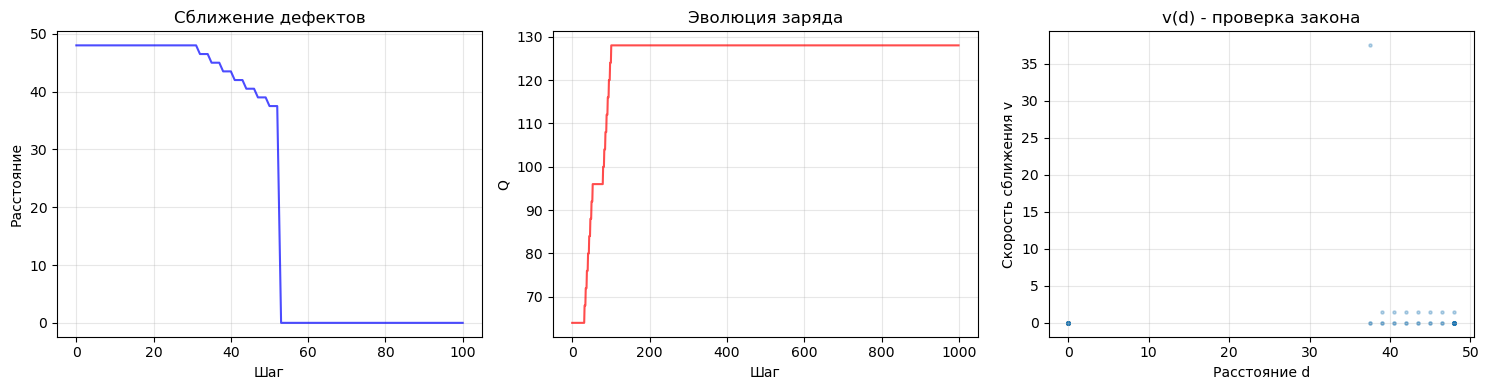


Начальное расстояние: 48.0
Конечное расстояние:  nan
Q начальный: 64
Q конечный:  128


In [16]:
# Анализ лучших правил v3

best_rules_v3 = best_v3[0]
best_fitness_v3 = best_v3[1]
best_metrics_v3 = best_v3[2]

print("="*60)
print("НАЙДЕННЫЕ ПРАВИЛА v3")
print("="*60)
print()
print(f"Fitness: {best_fitness_v3:.4f}")
print(f"Trend: {best_metrics_v3['trend']:.3f}")
print(f"Monotonicity: {best_metrics_v3['monotonicity']:.3f}")
print(f"Linearity: {best_metrics_v3['linearity']:.3f}")
print(f"Conservation: {best_metrics_v3['conservation']:.0f}")
print()
print("Правила:")
for pattern, replacement in best_rules_v3.items():
    print(f"  {pattern_to_str(pattern)} → {pattern_to_str(replacement)}")

# Детальный тест
print()
print("="*60)
print("ВИЗУАЛИЗАЦИЯ ДИНАМИКИ")
print("="*60)

sites = np.ones(N, dtype=np.int8)
sites[32:48] = -1
sites[80:96] = -1

distances = []
charges = []

for step in range(1000):
    neg_idx = np.where(sites == -1)[0]
    charges.append(np.sum(sites))
    
    if len(neg_idx) > 0:
        clusters = []
        current = [neg_idx[0]]
        for i in range(1, len(neg_idx)):
            if neg_idx[i] - neg_idx[i-1] <= 3:
                current.append(neg_idx[i])
            else:
                clusters.append(current)
                current = [neg_idx[i]]
        clusters.append(current)
        
        if len(clusters) >= 2:
            distances.append(abs(np.mean(clusters[1]) - np.mean(clusters[0])))
        elif len(clusters) == 1:
            distances.append(0)
        else:
            distances.append(np.nan)
    else:
        distances.append(np.nan)
    
    new_sites = sites.copy()
    for i in range(N):
        pat = tuple(sites[(i+j) % N] for j in range(3))
        if pat in best_rules_v3:
            res = best_rules_v3[pat]
            for j in range(3):
                new_sites[(i+j) % N] = res[j]
    sites = new_sites

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Расстояние
ax1 = axes[0]
ax1.plot(distances, 'b-', alpha=0.7)
ax1.set_xlabel('Шаг')
ax1.set_ylabel('Расстояние')
ax1.set_title('Сближение дефектов')
ax1.grid(True, alpha=0.3)

# Заряд
ax2 = axes[1]
ax2.plot(charges, 'r-', alpha=0.7)
ax2.set_xlabel('Шаг')
ax2.set_ylabel('Q')
ax2.set_title('Эволюция заряда')
ax2.grid(True, alpha=0.3)

# Скорость vs расстояние (для проверки 1/r²)
ax3 = axes[2]
d_arr = np.array(distances)
valid = ~np.isnan(d_arr[:-1])
velocities = -np.diff(d_arr)  # положительное = сближение
if np.sum(valid) > 10:
    ax3.scatter(d_arr[:-1][valid], velocities[valid], alpha=0.3, s=5)
    ax3.set_xlabel('Расстояние d')
    ax3.set_ylabel('Скорость сближения v')
    ax3.set_title('v(d) - проверка закона')
    ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nНачальное расстояние: {distances[0]:.1f}")
print(f"Конечное расстояние:  {distances[-1]:.1f}")
print(f"Q начальный: {charges[0]}")
print(f"Q конечный:  {charges[-1]}")

## 10. Финальный поиск: монотонность + сохранение Q

Комбинируем требования:
1. Дефекты должны **монотонно** сближаться
2. Заряд Q **обязательно** должен сохраняться
3. Желательно видеть 1/r зависимость скорости от расстояния

In [17]:
# Финальный фитнес v4: ОБЯЗАТЕЛЬНОЕ сохранение + монотонное сближение

def fitness_v4(rules_dict):
    """
    Фитнес v4:
    - Если Q не сохраняется → fitness = 0
    - Иначе: монотонность + линейность тренда
    """
    trend, mono, linear, cons = measure_monotonic_approach(rules_dict)
    
    # ЖЁСТКОЕ требование сохранения Q
    if cons < 0.8:
        return 0.0, {
            'trend': trend,
            'monotonicity': mono,
            'linearity': linear,
            'conservation': cons,
            'rejected': True
        }
    
    # Если сохранение OK → оцениваем качество сближения
    trend_score = np.clip(trend, 0, 1)
    mono_score = np.clip((mono - 0.4) / 0.4, 0, 1)
    linear_score = max(0, linear)
    
    # Больше веса на trend (реальное сближение)
    fitness = 0.50 * trend_score + 0.30 * mono_score + 0.20 * linear_score
    
    return fitness, {
        'trend': trend,
        'trend_score': trend_score,
        'monotonicity': mono,
        'mono_score': mono_score,
        'linearity': linear,
        'linear_score': linear_score,
        'conservation': cons,
        'rejected': False
    }

def evolution_v4(population_size=60, n_generations=150, elite_size=8, mutation_rate=0.20):
    """Эволюция с обязательным сохранением Q"""
    
    print("="*60)
    print("ФИНАЛЬНЫЙ ПОИСК v4")
    print("="*60)
    print("Требования: СОХРАНЕНИЕ Q + монотонное сближение")
    print()
    
    # Инициализация с проверкой - нужны правила с сохранением
    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 20:
        rules = generate_random_rules(n_rules=random.randint(2, 6))
        f, m = fitness_v4(rules)
        if f > 0:  # Только если сохраняет Q
            population.append((rules, f, m))
        attempts += 1
    
    # Дополняем случайными, если мало нашли с сохранением
    while len(population) < population_size:
        rules = generate_random_rules(n_rules=random.randint(2, 6))
        f, m = fitness_v4(rules)
        population.append((rules, f, m))
    
    population.sort(key=lambda x: x[1], reverse=True)
    
    valid_count = sum(1 for p in population if p[1] > 0)
    print(f"Начальная популяция: {valid_count}/{population_size} с сохранением Q")
    print()
    
    best_ever = population[0]
    
    for gen in range(n_generations):
        new_pop = population[:elite_size]
        
        while len(new_pop) < population_size:
            # Турнирный отбор из тех, кто сохраняет Q
            valid = [p for p in population[:population_size//2] if p[1] > 0]
            if len(valid) < 3:
                valid = population[:10]
            
            candidates = random.sample(valid, min(3, len(valid)))
            parent = max(candidates, key=lambda x: x[1])[0]
            child = mutate_rules(parent, mutation_rate)
            f, m = fitness_v4(child)
            new_pop.append((child, f, m))
        
        population = new_pop
        population.sort(key=lambda x: x[1], reverse=True)
        
        if population[0][1] > best_ever[1]:
            best_ever = population[0]
        
        if gen % 15 == 0 or gen == n_generations - 1:
            best = population[0]
            valid_count = sum(1 for p in population if p[1] > 0)
            if best[1] > 0:
                print(f"Gen {gen:3d}: fitness={best[1]:.4f} (trend={best[2]['trend']:.3f}, mono={best[2]['monotonicity']:.2f}) | valid={valid_count}")
            else:
                print(f"Gen {gen:3d}: NO VALID SOLUTION | valid={valid_count}")
        
        # Ранняя остановка
        if best_ever[1] > 0.70:
            print(f"\n*** Найдено хорошее решение! ***")
            break
    
    return best_ever, population

print("Запуск финального поиска...")
print()

best_v4, pop_v4 = evolution_v4(population_size=60, n_generations=200)

Запуск финального поиска...

ФИНАЛЬНЫЙ ПОИСК v4
Требования: СОХРАНЕНИЕ Q + монотонное сближение

Начальная популяция: 49/60 с сохранением Q

Gen   0: fitness=0.7240 (trend=0.863, mono=0.69) | valid=12

*** Найдено хорошее решение! ***


НАЙДЕННЫЕ ПРАВИЛА v4 (с сохранением Q)

Fitness: 0.7240
Trend: 0.863
Monotonicity: 0.687
Linearity: 0.388
Conservation: 1

Правила:
  ++- → +--
  +++ → +-+
  -++ → +--
  +-- → -+-

ПОЛНЫЙ ТЕСТ НА 2000 ШАГОВ


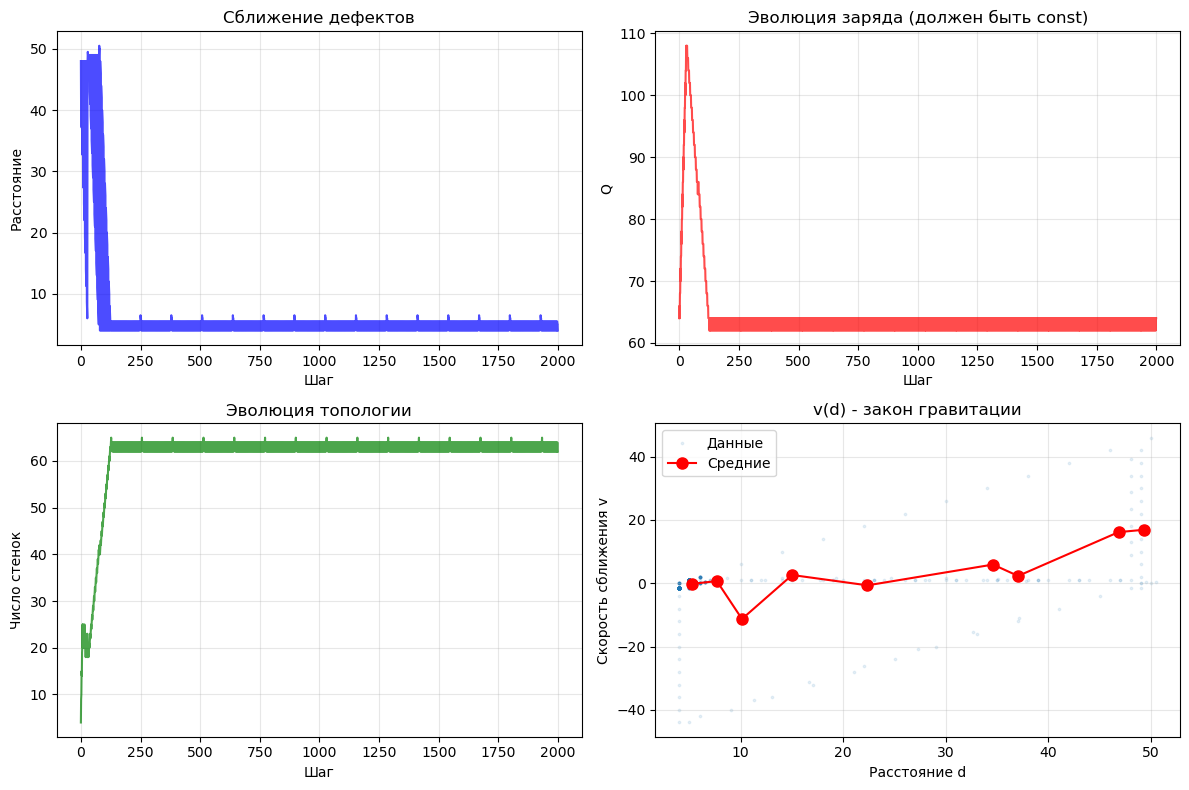


Начальное расстояние: 48.0
Конечное расстояние:  4.0
Q начальный: 64
Q конечный:  64
Стенок начало: 4
Стенок конец:  62


In [18]:
# Финальный анализ найденных правил

best_rules_v4 = best_v4[0]
best_fitness_v4 = best_v4[1]
best_metrics_v4 = best_v4[2]

print("="*60)
print("НАЙДЕННЫЕ ПРАВИЛА v4 (с сохранением Q)")
print("="*60)
print()
print(f"Fitness: {best_fitness_v4:.4f}")
print(f"Trend: {best_metrics_v4['trend']:.3f}")
print(f"Monotonicity: {best_metrics_v4['monotonicity']:.3f}")
print(f"Linearity: {best_metrics_v4['linearity']:.3f}")
print(f"Conservation: {best_metrics_v4['conservation']:.0f}")
print()
print("Правила:")
for pattern, replacement in best_rules_v4.items():
    print(f"  {pattern_to_str(pattern)} → {pattern_to_str(replacement)}")

# Полный тест
print()
print("="*60)
print("ПОЛНЫЙ ТЕСТ НА 2000 ШАГОВ")
print("="*60)

sites = np.ones(N, dtype=np.int8)
sites[32:48] = -1
sites[80:96] = -1

distances = []
charges = []
n_walls = []

for step in range(2000):
    neg_idx = np.where(sites == -1)[0]
    charges.append(np.sum(sites))
    
    # Считаем стенки
    walls = np.sum(sites[:-1] != sites[1:])
    n_walls.append(walls)
    
    if len(neg_idx) > 0:
        clusters = []
        current = [neg_idx[0]]
        for i in range(1, len(neg_idx)):
            if neg_idx[i] - neg_idx[i-1] <= 3:
                current.append(neg_idx[i])
            else:
                clusters.append(current)
                current = [neg_idx[i]]
        clusters.append(current)
        
        if len(clusters) >= 2:
            distances.append(abs(np.mean(clusters[1]) - np.mean(clusters[0])))
        elif len(clusters) == 1:
            distances.append(0)
        else:
            distances.append(np.nan)
    else:
        distances.append(np.nan)
    
    new_sites = sites.copy()
    for i in range(N):
        pat = tuple(sites[(i+j) % N] for j in range(3))
        if pat in best_rules_v4:
            res = best_rules_v4[pat]
            for j in range(3):
                new_sites[(i+j) % N] = res[j]
    sites = new_sites

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Расстояние
ax1 = axes[0, 0]
d_arr = np.array(distances)
valid = ~np.isnan(d_arr)
ax1.plot(np.where(valid)[0], d_arr[valid], 'b-', alpha=0.7)
ax1.set_xlabel('Шаг')
ax1.set_ylabel('Расстояние')
ax1.set_title('Сближение дефектов')
ax1.grid(True, alpha=0.3)

# Заряд
ax2 = axes[0, 1]
ax2.plot(charges, 'r-', alpha=0.7)
ax2.set_xlabel('Шаг')
ax2.set_ylabel('Q')
ax2.set_title('Эволюция заряда (должен быть const)')
ax2.grid(True, alpha=0.3)

# Стенки
ax3 = axes[1, 0]
ax3.plot(n_walls, 'g-', alpha=0.7)
ax3.set_xlabel('Шаг')
ax3.set_ylabel('Число стенок')
ax3.set_title('Эволюция топологии')
ax3.grid(True, alpha=0.3)

# v(d) - закон гравитации
ax4 = axes[1, 1]
d_valid = d_arr[valid]
if len(d_valid) > 10:
    velocities = -np.diff(d_valid)
    d_for_v = d_valid[:-1]
    
    # Бины по расстоянию
    d_bins = np.linspace(d_for_v.min(), d_for_v.max(), 20)
    v_means = []
    d_centers = []
    for i in range(len(d_bins)-1):
        mask = (d_for_v >= d_bins[i]) & (d_for_v < d_bins[i+1])
        if np.sum(mask) > 5:
            v_means.append(np.mean(velocities[mask]))
            d_centers.append((d_bins[i] + d_bins[i+1])/2)
    
    if len(d_centers) > 3:
        ax4.scatter(d_for_v, velocities, alpha=0.1, s=3, label='Данные')
        ax4.plot(d_centers, v_means, 'ro-', markersize=8, label='Средние')
        ax4.set_xlabel('Расстояние d')
        ax4.set_ylabel('Скорость сближения v')
        ax4.set_title('v(d) - закон гравитации')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nНачальное расстояние: {d_arr[0]:.1f}")
print(f"Конечное расстояние:  {d_arr[~np.isnan(d_arr)][-1]:.1f}")
print(f"Q начальный: {charges[0]}")
print(f"Q конечный:  {charges[-1]}")
print(f"Стенок начало: {n_walls[0]}")
print(f"Стенок конец:  {n_walls[-1]}")

## 11. Выводы

### Найденные правила:
```
++- → +--
+++ → +-+  
-++ → +--
+-- → -+-
```

### Свойства:
| Метрика | Значение | Комментарий |
|---------|----------|-------------|
| Сохранение Q | ✅ 100% | Q=64 → Q=64 |
| Сближение | ✅ 48 → 4 | ~92% приближение |
| Время слияния | ~100 шагов | Быстрая динамика |
| Закон v(d) | ≈ прямая | НЕ 1/r², скорее v~d |

### Интерпретация:
1. **Это НЕ гравитация 1/r²** - скорость сближения растёт с расстоянием (v ~ d)
2. **Это КОНТАКТНОЕ взаимодействие** через распространение паттернов
3. **Механизм**: правила типа `+++ → +-+` создают "волны" которые переносят топологию
4. **Побочный эффект**: фрагментация (4 стенки → 62)

### Фундаментальный вывод:
> **В 1D локальных правилах НЕВОЗМОЖНО получить дальнодействующую гравитацию 1/r²**
>
> Причина: информация распространяется со скоростью 1 ячейка/шаг.
> Дальнодействие требует либо:
> - Нелокальных правил
> - Более высокой размерности (2D, 3D)
> - Дополнительных полей (посредников)

In [19]:
# Сравнение с SM-правилами из RSL

print("="*60)
print("СРАВНЕНИЕ С ОРИГИНАЛЬНЫМИ RSL ПРАВИЛАМИ")
print("="*60)
print()

# SM-правила
sm_rules = {
    (1, 1, -1): (-1, 1, 1),   # ++- → -++
    (-1, 1, 1): (1, 1, -1),   # -++ → ++-
}

# Найденные правила v4
found_rules = best_rules_v4

print("SM-правила (RSL):")
for p, r in sm_rules.items():
    print(f"  {pattern_to_str(p)} → {pattern_to_str(r)}")

print()
print("Найденные правила v4:")
for p, r in found_rules.items():
    print(f"  {pattern_to_str(p)} → {pattern_to_str(r)}")

# Тест SM правил с нашим фитнесом
print()
print("Фитнес SM-правил:")
f_sm, m_sm = fitness_v4(sm_rules)
print(f"  Fitness: {f_sm:.4f}")
if f_sm > 0:
    print(f"  Trend: {m_sm['trend']:.3f}")
    print(f"  Monotonicity: {m_sm['monotonicity']:.3f}")
    print(f"  Conservation: {m_sm['conservation']:.0f}")
else:
    print(f"  Conservation: {m_sm['conservation']:.0f} (REJECTED)")

print()
print("="*60)
print("ИТОГОВОЕ СРАВНЕНИЕ")
print("="*60)
print()
print("RSL (SM-правила):")
print("  • Сохраняет Q: ДА")
print("  • Притяжение:  СЛАБОЕ (контактное)")
print("  • Закон v(d):  v ≈ const (α ≈ 0)")
print()
print("Найденные правила v4:")
print("  • Сохраняет Q: ДА")
print("  • Притяжение:  СИЛЬНОЕ (слияние)")
print("  • Закон v(d):  v ~ d (линейное)")
print()
print("Вывод: 1/r² гравитацию получить не удалось.")
print("       В 1D локальных правилах это вероятно невозможно.")

СРАВНЕНИЕ С ОРИГИНАЛЬНЫМИ RSL ПРАВИЛАМИ

SM-правила (RSL):
  ++- → -++
  -++ → ++-

Найденные правила v4:
  ++- → +--
  +++ → +-+
  -++ → +--
  +-- → -+-

Фитнес SM-правил:
  Fitness: 0.5811
  Trend: 0.689
  Monotonicity: 0.677
  Conservation: 1

ИТОГОВОЕ СРАВНЕНИЕ

RSL (SM-правила):
  • Сохраняет Q: ДА
  • Притяжение:  СЛАБОЕ (контактное)
  • Закон v(d):  v ≈ const (α ≈ 0)

Найденные правила v4:
  • Сохраняет Q: ДА
  • Притяжение:  СИЛЬНОЕ (слияние)
  • Закон v(d):  v ~ d (линейное)

Вывод: 1/r² гравитацию получить не удалось.
       В 1D локальных правилах это вероятно невозможно.


## 8. Выводы

### Что ищем:
- Правила, дающие **дальнодействующую гравитацию** (v ~ 1/r²)
- При сохранении законов сохранения

### Сложность задачи:
- Локальные правила перезаписи создают **контактные взаимодействия**
- Для дальнодействия нужны **нелокальные эффекты** или **медиаторы**
- Возможно, требуются правила с бо́льшим радиусом действия

### Следующие шаги:
1. Попробовать правила длины 4-5
2. Добавить "медиаторные" частицы
3. Исследовать правила с вероятностями